<a href="https://colab.research.google.com/github/nssn96/ML_Neural-networks/blob/main/ML_nn_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment 2 - Neural Networks


1.   Author : Surya Narayanan Nadhamuni Suresh
2.   UTA ID : 1001877873


In [80]:
#import lines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import random
import pickle

In [81]:
#References Used
#https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba
#https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
#https://towardsdatascience.com/an-introduction-to-neural-networks-with-implementation-from-scratch-using-python-da4b6a45c05b
#https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
#https://dillhoffaj.utasites.cloud/posts/neural_networks/

# This is the Layer class

class Layer:

  def initial_w_bias(self,nn):
    param = {}
    #creating the values for the w and bias matrix
    for i in range(1,len(nn)):
      param['w' + str(i)] = np.random.randn(nn[i], nn[i-1])*0.01
      param['b' + str(i)] = np.random.randn(nn[i],1)*0.01
    return param


In [82]:
#This is the class for the hyperbolic tangent functions

#class htangent_activation(Layer):

def tanh_forwardprop(z):
  #2/(1 + e-2x) - 1
  return (2/(1+np.exp(-2*z)) -1)

def tanh_backprop(dA,z):
  value = tanh_forwardprop(z)
  return dA * value * (1-value)


In [83]:
#This is the class for the sigmoid function

#class sigmoid_activation(Layer):

def sigmoid_forwardprop(Z):
  return 1/(1+np.exp(-Z))
  
def sigmoid_backprop(dA,z):
  value = sigmoid_forwardprop(z)
  return dA * value * (1-value)

In [84]:
#This is the class for the softmax function

class softmax_activation(Layer):

  def softmax_forwardprop(self,z):
    return np.exp(z) / sum(np.exp(z))
  

  #derivative of softmax
  def softmax_backprop(self,z):
    exp=np.exp(z-z.max())
    return exp/np.sum(exp,axis=0)*(1-exp/np.sum(exp,axis=0))
    



  
  #Yet to edit this--- DONT FORGET+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # def softmax_backprop(probs, bp_err):
  #   dim = probs.shape[1]
  #   output = np.empty(probs.shape)
  #   for j in range(dim):
  #       d_prob_over_xj = - (probs * probs[:,[j]])  # i.e. prob_k * prob_j, no matter k==j or not
  #       d_prob_over_xj[:,j] += probs[:,j]   # i.e. when k==j, +prob_j
  #       output[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
  #   return output
  

In [85]:
# This is the Linear layer class

class LinearLayer(Layer):


  def forward(self,data,param,flag):
    
    #Z_mat = np.dot(w,prev_out)
    
    layer_num = len(param)//2
    #print(layer_num)
    backup = {} # to store info required for the backward calculation

    #traversing over the layers in the neural network
    #this is the same steps that we used to assign the weights and bias for network
    for i in range(1,layer_num+1):
      #if it is the first iteration the input will be the input ie the train or the test data
      w = param['w'+str(i)]
      bias = param['b'+str(i)]
      if i==1:
        #Z_mat--> the input matrix calculation which will be passed in the activation function
        backup['Z' + str(i)] = np.dot(w, data) + bias
        if flag=='t':
          backup['A' + str(i)] = tanh_forwardprop(backup['Z' + str(i)])
        else:
          backup['A' + str(i)] = sigmoid_forwardprop(backup['Z' + str(i)])

      else:
        backup['Z' + str(i)] = np.dot(w, backup['A' + str(i-1)]) + bias
        if i==layer_num:
          backup['A' + str(i)] = backup['Z' + str(i)]
        else:
          if flag=='t':
            backup['A' + str(i)] = tanh_forwardprop(backup['Z' + str(i)])
          else:
            backup['A' + str(i)] = sigmoid_forwardprop(backup['Z' + str(i)])


      #storing the values for backward pass call
      #backup['Z' + str(i)] = Z_mat

    
    # for i in backup.keys():
    #   print(i)
    return backup
  
  def compute_loss(self,backup,target):
    layer_num = len(backup)//2
    y_pred = backup['A' + str(layer_num)]
    loss = cost = 1/(2*len(target)) * np.sum(np.square(y_pred - target))
    return loss
  
  def compute_loss_backward(self,backup,target): # target--> Z_mat value , backup--> dict values
    layer_num = len(backup)//2
    loss=0
    y_pred = backup['A' + str(layer_num)]
    for i in range(len(target)):
      loss+= (target[i] - y_pred[0][i])/len(target)
    return loss
  
  def backward(self,data,target,param,backup,loss):
    deriv_values= {}  #dictionary to store the derivative values
    layer_num = len(param)//2
    n = len(target)
     #since we need to go backward in backward propagation
    for i in range(layer_num,0,-1):

      # print(i)
      # print(backup['A'+str(i)])
      A_previous = backup['A'+str(i)]
      z_current = backup['Z'+str(i)]
      w = param['w'+str(i)]
      bias = param['b'+str(i)]

      if i == layer_num:
        dA_current = 1/n * (A_previous - target)
        dz = dA_current
      else:
        dA_current = np.dot(param['w' + str(i+1)].T, dz)
        dz = np.multiply(dA_current, np.where(A_previous>=0, 1, 0)) #original one
        #dz = np.multiply(loss, np.where(A_previous>=0, 1, 0))

      #backward tanh
      #dA_current = tanh_backprop(dA_current,z_current)
      
      if i==1:
        #dw = 1/n * np.dot(dz, data.T)
        dw = 1/n * np.dot(dz, data)
        dbias = 1/n * np.sum(dz, axis=1, keepdims=True)
      else:
        dw = 1/n * np.dot(dz,backup['A' + str(i-1)].T)
        dbias = 1/n * np.sum(dz, axis=1, keepdims=True)
      
      
      deriv_values['dw' + str(i)] = dw
      deriv_values['db' + str(i)] = dbias

    # for i in deriv_values.keys():
    #   print(i)
    return deriv_values
  
  def update_param(self,param,deriv_values,alpha):
    layer_num = len(param)//2
    updated_param = {}
    for i in range(1,layer_num+1):
      updated_param['w'+str(i)] = param['w' + str(i)] - alpha * deriv_values['dw' + str(i)]
      updated_param['b'+str(i)] = param['b' + str(i)] - alpha * deriv_values['db' + str(i)]
    return updated_param





In [86]:
# This is the class for entropy loss

class entropy_loss(LinearLayer):

  def cross_entropy_forward(self,y_pred,y):
    return -y * np.log(y_pred)
  
  def cross_entropy_backward(self,y_pred,y):
    return y-y_pred


In [87]:
#This part of the code is for sequential class

class Sequential(LinearLayer):

  def train(self,data,target,nn,steps,alpha,modelname,flag='t'):
    param = self.initial_w_bias(nn)
    epoch_arr =[]
    loss_arr =[]
    
    for i in range(steps):
      backup = self.forward(data.T, param,flag)
      loss = self.compute_loss(backup,target.T)   #original one
      #loss = self.compute_loss_backward(backup,target)
      deriv_values = self.backward(data,target,param,backup,loss)
      param = self.update_param(param,deriv_values,alpha)
      loss_arr.append(loss)
      epoch_arr.append(i+1)
      
      #print('Iteration ' + str(i+1) + ' , Loss = ' + str(loss) + '\n')
    
    # To plot the loss vs epoch
    fig = plt.figure(figsize=[6,10])
    ax = fig.add_subplot(1,1, 1)
    ax.plot(epoch_arr,loss_arr, color='b', linestyle="-")
    ax.set_title(modelname)
    ax.set_xlabel('number of Epochs')
    ax.set_ylabel('Loss value')
    return param
  
  
  
  def accuracy_calc(self,x_train,x_test,y_train,y_test,param,nn):
    backup_test = self.forward(x_test.T,param)
    backup_train = self.forward(x_train.T,param)
    accuracy_train = np.sqrt(mean_squared_error(y_train, backup_train['A' + str(len(nn)-1)].T))
    test_acc = np.sqrt(mean_squared_error(y_test, backup_test['A' + str(len(nn)-1)].T))
  
  def predict(self,data,param,flag='t'):
    backup = self.forward(data.T,param,flag)
    pred = backup['A' + str(len(backup)//2)].T
    return pred


In [88]:
data = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
target = np.array([0, 1, 1, 0])
#target = np.array(([0],[1],[1],[0]))

In [89]:
# data = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
# target = np.array([[[0]], [[1]], [[1]], [[0]]])

[[0.42692029]
 [0.42692352]
 [0.42691633]
 [0.42691956]]


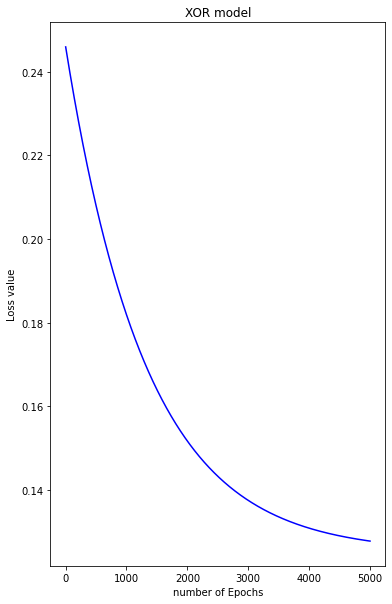

In [90]:
#training part
net = Sequential()
layers = [2,2,2,1]                                                        
steps = 5000                                                                 
alpha = 0.001                                                        
param = net.train(data, target, layers, steps, alpha,'XOR model','s')          
# train_acc, test_acc = accuracy_calc(X_train, X_test, Y_train, Y_test, params)  
# print('Root Mean Squared Error on Training Data = ' + str(train_acc))
# print('Root Mean Squared Error on Test Data = ' + str(test_acc))

#predict part
y_pred = net.predict(data,param,'s')
print(y_pred)


# MNIST dataset

In [91]:
#MNIST dataset
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#reshape the input data
x_train = x_train.reshape(x_train.shape[0], 28*28)
#normalizing the input data
x_train = x_train.astype('float32')
x_train /= 255
aay_train = np_utils.to_categorical(y_train)

# same for test data
x_test = x_test.reshape(x_test.shape[0],28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)


In [92]:
# #normalize x
# x_train = x_train.astype(float)/255.
# x_test = x_test.astype(float)/255.

# #creating a validation set for 10% dataset(10000 training examples)
# x_train,x_validation = x_train[:-10000], x_train[-10000:]
# y_train,y_validation = y_train[:-10000], y_train[-10000:]

# #flattening and reshaping
# x_train = x_train.reshape([x_train.shape[0], -1])
# x_val = x_validation.reshape([x_validation.shape[0], -1])
# x_test = x_test.reshape([x_test.shape[0], -1])

In [93]:
# To check some examples of how the input data looks
# plt.figure(figsize=[7,7])
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     i=random.randint(1, 9)
#     print(y_train[i])
#     plt.title("Value: %i"%y_train[i])
#     plt.imshow(x_train[i].reshape([28,28]),cmap='gray');

In [94]:
#changing to categorical form
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)


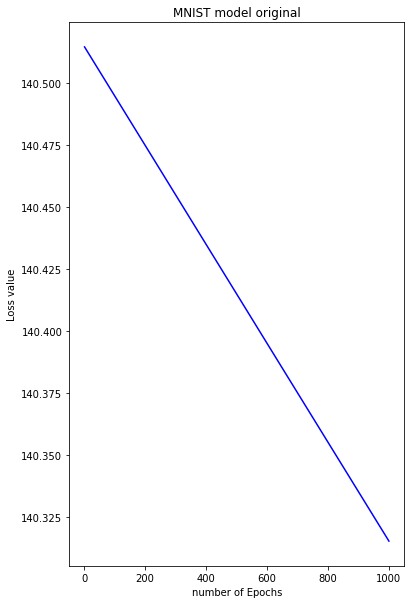

In [95]:
# creating the neural net for the mnist dataset and creating objects to use
mnist_nn = [(28*28),100,100,50,50,10]
mnist_net = Sequential()
#def train(self,data,target,nn,steps,alpha): 
param = mnist_net.train(x_train[0:1000], y_train[0:1000].T,mnist_nn, 1000, 0.001,'MNIST model original')



In [96]:
#saving the the neural network size and parameteres using pickle function
with open('XOR_solved.w', 'wb') as files:
  pickle.dump(mnist_nn, files) #the neural network size is in the form of list that has each input and output size
  pickle.dump(param, files) # the dictionary variable that has the weights and bias for the network

In [97]:
samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)


Num 1
Num_true 7
Num 7
Num_true 2
Num 3
Num_true 1
Num 4
Num_true 0
Num 2
Num_true 4
Num 6
Num_true 1
Num 8
Num_true 4
Num 8
Num_true 9
Num 8
Num_true 5
Num 8
Num_true 9


# Experiment with at least 3 configurations of hyperparameters.

=======================================This is for Model 1==========================================
Num 1
Num_true 7
Num 8
Num_true 2
Num 1
Num_true 1
Num 1
Num_true 0
Num 1
Num_true 4
Num 1
Num_true 1
Num 1
Num_true 4
Num 1
Num_true 9
Num 1
Num_true 5
Num 1
Num_true 9


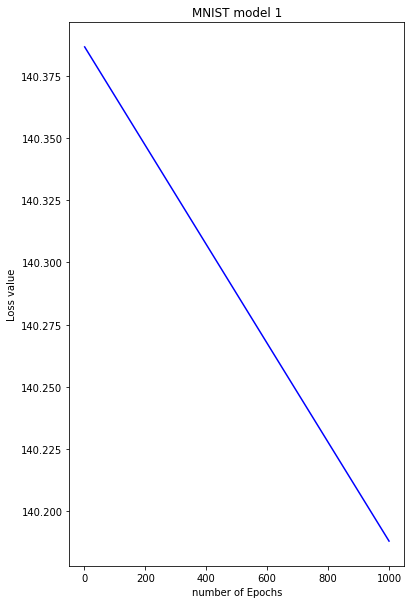

In [98]:
#for this section , I will be changing the three parameters and observer the output
# Model 1 --> Changing the number of nodes in layers --> I will be changing this [(28*28),100,100,50,50,10] to [(28*28),30,30,50,50,10]
# Model 2 --> Changing the learning parameter to 0.9
# Model 3 --> Changing the activation in every layer to sigmoid activation
#Lets see the output for these three changes

#Model 1--> configuration
mnist_nn_1 = [(28*28),30,30,50,50,10]
mnist_net_1 = Sequential() 
param = mnist_net_1.train(x_train[0:1000], y_train[0:1000].T,mnist_nn_1, 1000, 0.001,'MNIST model 1')

print("=======================================This is for Model 1==========================================")
samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net_1.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)


=======================================This is for Model 2==========================================
Num 9
Num_true 7
Num 5
Num_true 2
Num 8
Num_true 1
Num 1
Num_true 0
Num 2
Num_true 4
Num 8
Num_true 1
Num 7
Num_true 4
Num 4
Num_true 9
Num 5
Num_true 5
Num 9
Num_true 9


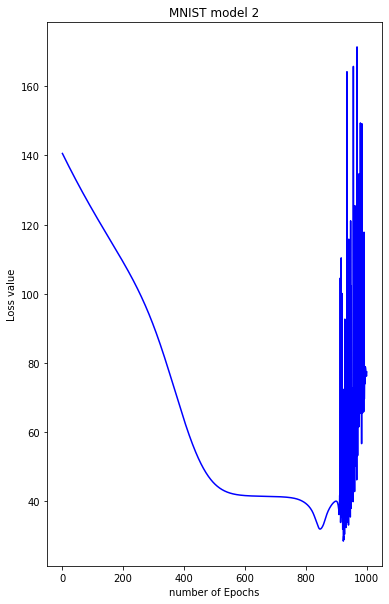

In [99]:
#Model 2--> configuration
mnist_nn_2 = [(28*28),100,100,50,50,10]
mnist_net_2 = Sequential() 
param = mnist_net_2.train(x_train[0:1000], y_train[0:1000].T,mnist_nn_2, 1000, 0.9,'MNIST model 2')

print("=======================================This is for Model 2==========================================")
samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net_2.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)


=======================================This is for Model 3==========================================
Num 3
Num_true 7
Num 4
Num_true 2
Num 7
Num_true 1
Num 6
Num_true 0
Num 7
Num_true 4
Num 7
Num_true 1
Num 8
Num_true 4
Num 3
Num_true 9
Num 6
Num_true 5
Num 2
Num_true 9


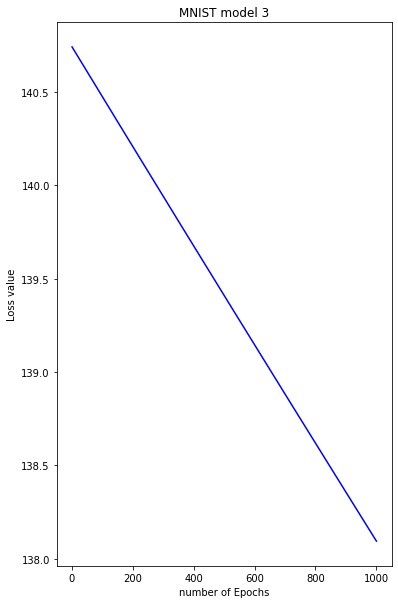

In [100]:
#Model 3--> configuration
mnist_nn_3 = [(28*28),100,100,50,50,10]
mnist_net_3 = Sequential() 
param = mnist_net_3.train(x_train[0:1000], y_train[0:1000].T,mnist_nn_3, 1000, 0.001,'MNIST model 3','s') # this flag 's' will change all the activation to sigmoid activation

samples = 10
print("=======================================This is for Model 3==========================================")
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net_3.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)

# Playing with Hyperparameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


=======================================This is for MNIST model learning rate 1==========================================
Num 2
Num_true 7
Num 9
Num_true 2
Num 1
Num_true 1
Num 7
Num_true 0
Num 2
Num_true 4
Num 1
Num_true 1
Num 4
Num_true 4
Num 7
Num_true 9
Num 9
Num_true 5
Num 2
Num_true 9
=======================================This is for MNIST model learning rate 0.001 ==========================================
Num 3
Num_true 7
Num 9
Num_true 2
Num 8
Num_true 1
Num 1
Num_true 0
Num 8
Num_true 4
Num 8
Num_true 1
Num 9
Num_true 4
Num 8
Num_true 9
Num 3
Num_true 5
Num 9
Num_true 9


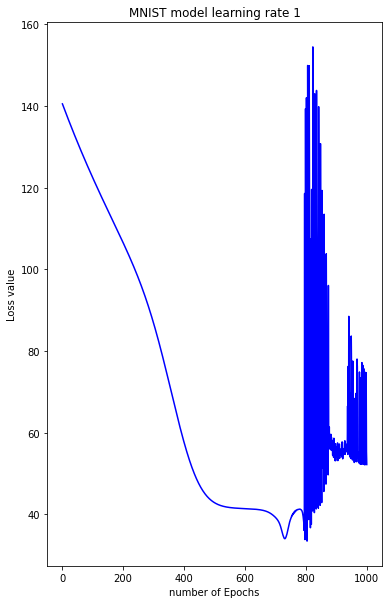

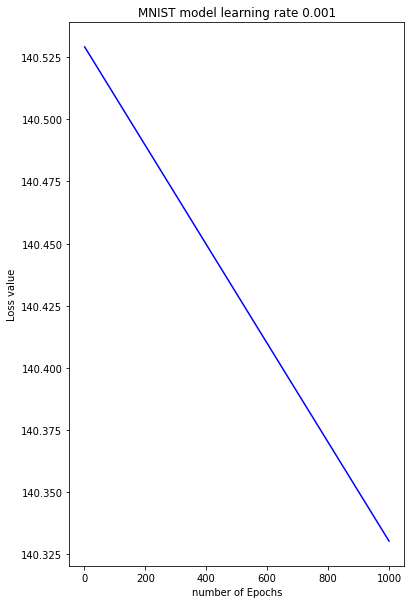

In [101]:
#Train on MNIST using a learning rate of 1 and then again with a learning rate of 0.001. Plot the training loss curve in both instances.

###############learning rate --> 1

#Model model learning rate 1--> configuration
mnist_nn_lr1 = [(28*28),100,100,50,50,10]
mnist_net_lr1 = Sequential() 
param = mnist_net_lr1.train(x_train[0:1000], y_train[0:1000].T,mnist_nn_lr1, 1000, 1,'MNIST model learning rate 1')

print("=======================================This is for MNIST model learning rate 1==========================================")
samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net_lr1.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)

######################learning rate --> 0.001

#Model model learning rate  0.001 --> configuration
mnist_nn_lr2 = [(28*28),100,100,50,50,10]
mnist_net_lr2 = Sequential() 
param = mnist_net_lr2.train(x_train[0:1000], y_train[0:1000].T,mnist_nn_lr2, 1000, 0.001,'MNIST model learning rate 0.001')

print("=======================================This is for MNIST model learning rate 0.001 ==========================================")
samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (28, 28))
    #plt.imshow(image, cmap='binary')
    #plt.show()
    pred = mnist_net_lr2.predict(test,param)
    #print(pred)
    num = np.argmax(pred)
    num_true = np.argmax(true)
    print('Num',str(num)[0])
    print('Num_true',num_true)

